In [31]:
from numpy.linalg import inv

class Kalman():
    '''Implements a 1D (observation dimension) Bayesian Kalman filter following the probabilistic approach of Murphy page ~641.
    '''
    
    def __init__(self, state_params, Y, mu_0, sigma_0, dt, A, B, C, D, Q, R):
        self.state_params = state_params # Specify the state vector. 
        self.Y = Y   # 1D 
        self.dt = dt # Timestep between observations
        self.A = A   # Parameter matrix A 
        self.B = B   # Parameter matrix B 
        self.C = C   # Parameter matrix C 
        self.D = D   # Parameter matrix D
        self.Q = Q   # State noise covaraiance matrix 
        self.R = R   # Observation noise covariance matrix
        self.S = self.R # Observation Noise Estimate. For now set to R 
        self.mu = mu_0 # Initial state estimate 
        self.sigma = sigma_0 # Initial state covariance 
        
        
    def predict(self, u=None): 
        ''' Murphy Sec. 18.3.1.1'''
        
        # Predicted state covariance 
        self.sigma = np.dot(np.dot(self.A, self.sigma), self.A.T) + self.Q
        
        # if there is no control input do not include it 
        if u is None:
            self.mu = np.dot(self.A, self.mu)  # Predict state mean 
        else:
            self.mu = np.dot(self.A, self.mu) + np.dot(self.B, self.u)

    
        
    def update(self, Y):
        ''' Murphy Sec. 18.3.1.2
        '''
        
        self.y = np.dot(self.C,self.mu) # Posterior predictive mean 
        self.sigma_y = np.dot(np.dot(self.C, self.sigma), self.C.T) + self.R
        
        r = Y - self.y # residual 
        S = np.dot(np.dot(self.C, self.sigma), self.C.T) + self.R #         
        K = np.dot(np.dot(self.sigma, self.C.T), inv(S)) # Kalman Gain 
        
        # Correct the state covariance and mean 
        self.mu = self.mu + np.dot(K, r)
        I_KC = np.identity(len(self.mu)) - np.dot(K,self.C)
        self.sigma = np.dot(np.dot(I_KC, self.sigma), I_KC.T) + np.dot(np.dot(K,self.R), K.T)
        
        self.K = K 
        self.S = S 
        
        #self.sigma = self.sigma - np.dot(np.dot(K,self.C),self.sigma)
        
        

In [103]:
import pandas as pd
import time 

def FilterSnowdepth(sensor_number, obs_noise, system_noise):
    
    df = pd.read_pickle('../output/cluster_0_cleaned.pickle')
    # Observations 
    Y = df['snowdepth_%i'%sensor_number].values
    
    # Let's estimate the initial baseline using the median of the first 2500 data points, excluding NaNs
    baseline = np.median(Y[:2500][~np.isnan(Y[:2500])])

    # Label the state parameters. 
    state_params=['depth_1', 'velocity_1', 'baseline_1']
    
    # First observation that is not nan 
    Y0 = Y[np.argwhere(~np.isnan(Y))[0]]
    sigma_0 = np.diag((50, 10, 10))
    mu_0 = np.array([-Y0+baseline, 0., baseline]) # Initial state is the first observation 
    dt = .25 # 15 minute intervals.  Velocity in mm/hr
    
    # Transition Matrix 
    A = np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]])

    # Control Model 
    B = np.zeros((len(mu_0),len(mu_0)))

    # Observation Matrix
    C = np.array([[-1, 0, +1],]) 

    # Process noise.
    Q = system_noise
    
    # Observation Noise
    R = obs_noise

    # For now, no control input 
    u = None
    D = None 

    K = Kalman(state_params, Y, mu_0, sigma_0, dt, A, B, C, D, Q, R)

    sigma_list  = np.zeros(len(Y)) 
    mu_list = np.zeros((len(Y),len(mu_0)))

    print 'Processing sensor %i'%sensor_number
    start = time.time()
    for i_obs in range(len(Y)-1):
        K.predict()
        
        # Only update the state if we are 
        if not np.isnan(Y[i_obs]):
            K.update(Y[i_obs])
        
        mu_list[i_obs] = K.mu
        sigma_list[i_obs] = K.S
                
        if (i_obs%500)==0:
            print '\r Forward pass on observation %i of %i'%(i_obs,len(Y)), 
    
    print '\n Completed Forward Pass in %1.2f s'%(time.time()-start)
    return mu_list, sigma_list

In [104]:
results = [FilterSnowdepth(i, obs_noise=50., system_noise=np.diag((1e-4,1e-4,1e-4)))
           for i in range(1,10)]


Processing sensor 1
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 2.00 s
Processing sensor 2
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 1.03 s
Processing sensor 3
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 1.89 s
Processing sensor 4
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 1.45 s
Processing sensor 5
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 1.73 s
Processing sensor 6
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 1.61 s
Processing sensor 7
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 1.82 s
Processing sensor 8
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 1.63 s
Processing sensor 9
 Forward pass on observation 17500 of 17569 
 Completed Forward Pass in 1.61 s


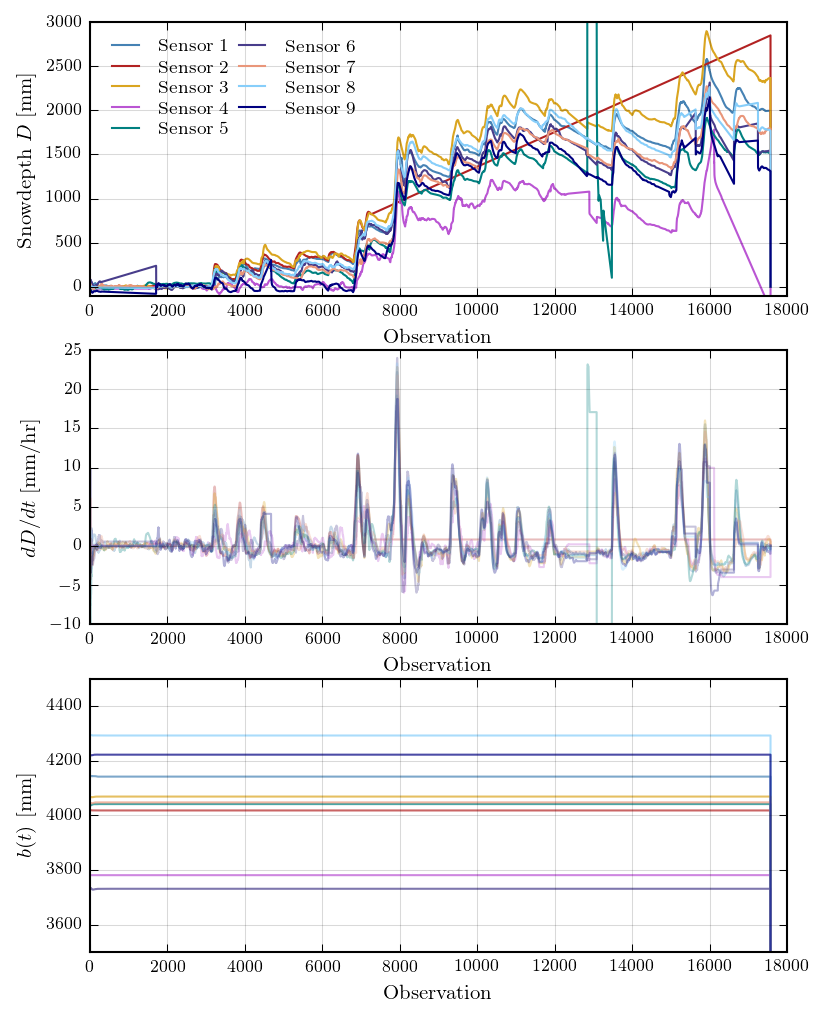

In [131]:

plt.figure(figsize=(6,8))
for i_sensor, (mu, sigma) in enumerate(results[:11]):
    
    # This sensor went out after not very long
#     if i_sensor==1: 
#         continue
    
    # Load the observations for plotting 
    df = pd.read_pickle('../output/cluster_0_cleaned.pickle')
    Y = df['snowdepth_%i'%(i_sensor+1)].values
    
    plt.subplot(311)
    # Plot the snowdepth 
    plt.plot(mu[:,0], label='Sensor %i'%(i_sensor+1))
    plt.xlabel('Observation')
    plt.ylabel('Snowdepth $D$ [mm]')
    plt.grid(linestyle='-', alpha=.15)
    plt.legend(loc=2, ncol=2, frameon=False, columnspacing=.2, labelspacing=.2)
    plt.ylim(-100, 3000)

    # Can also plot uncertainty bands, though these are not great yet.
    #plt.fill_between(range(len(mu[:,0])), mu[:,0]-sigma, mu[:,0]+sigma, alpha=.1, color='m')
    
    
    # -------------------------------
    # Plot the velocity parameter
    plt.subplot(312)
    plt.plot(mu[:,1], alpha=.3)
    plt.xlabel('Observation')
    plt.ylabel('$dD/dt$ [mm/hr]')
    plt.ylim(-10,25)
    plt.grid(linestyle='-', alpha=.15)
        
    # -------------------------------
    # Plot the baseline
    plt.subplot(313)
    plt.plot(mu[:,2], alpha=.7)
    plt.xlabel('Observation')
    plt.ylabel('$b(t)$ [mm]')
    plt.ylim(3.5e3,4.5e3)
    plt.grid(linestyle='-', alpha=.15)



